## Transverse field Ising model to demo primitives

In [1]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import YGate, UnitaryGate

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit.quantum_info import SparsePauliOp

In [5]:
SYGate = UnitaryGate(YGate().power(1/2),label = r"$\sqrt{Y}$")
SYdgGate = UnitaryGate(SYGate.inverse(),label = r"$\sqrt{Y}^\dag$")


def generate_1D_tfin_im(num_qubits,num_trotter_steps, rx_angle, num_cl_bits = 0, trotter_barriers = False, layer_barriers = False):
    if num_cl_bits == 0:
        qc = QuantumCircuit(num_qubits)
    else:
        qc = QuantumCircuit(num_qubits, num_cl_bits)
    for trotter_step in range(num_trotter_steps):
        add_1D_tfin_trotter_layer(qc,rx_angle, layer_barriers)
        if trotter_barriers:
            qc.barrier()
    return qc

def add_1D_tfin_trotter_layer(qc,rx_angle,layer_barriers = False):
    #Adding Rzz in even layers
    for i in range(0,qc.num_qubits-1,2):
        qc.sdg([i,i+1])
        qc.append(SYGate,[i+1])
        qc.cx(i,i+1)
        qc.append(SYdgGate,[i+1])
    if layer_barriers:
        qc.barrier()
    #Adding Rzz in odd layers
    for i in range(1,qc.num_qubits-1,2):
        qc.sdg([i,i+1])
        qc.append(SYGate,[i+1])
        qc.cx(i,i+1)
        qc.append(SYdgGate,[i+1])
    if layer_barriers:
        qc.barrier()

    qc.rx(rx_angle, list(range(qc.num_qubits)))
    if layer_barriers:
        qc.barrier()
        
    

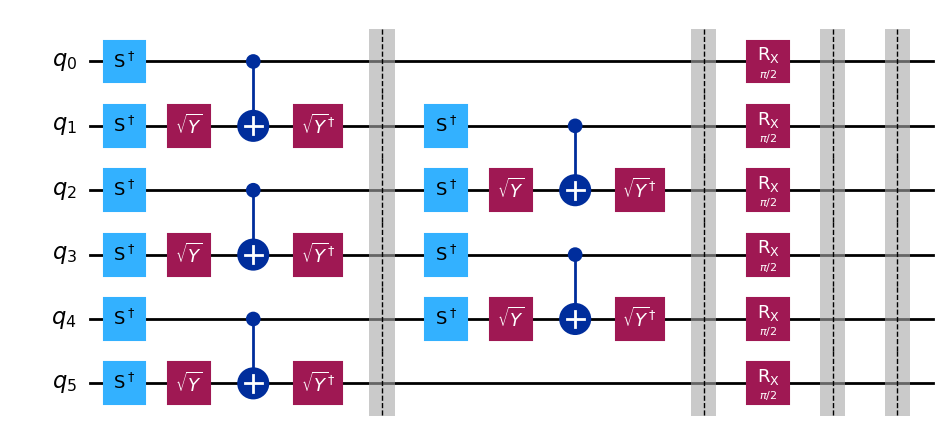

In [6]:
num_qubits = 6
num_trotter_steps = 1
rx_angle = 0.5*np.pi

qc = generate_1D_tfin_im(num_qubits,num_trotter_steps, rx_angle, trotter_barriers = True, layer_barriers = True)
qc.draw(output = "mpl")

In [7]:
def add_miirored_1D_tfin_im(qc, num_qubits,num_trotter_steps, rx_angle, trotter_barriers = False, layer_barriers = False):
    for trotter_step in range(num_trotter_steps):
        add_mirrored_1D_tfin_trotter_layer(qc,rx_angle, layer_barriers)
        if trotter_barriers:
            qc.barrier()

def add_mirrored_1D_tfin_trotter_layer(qc,rx_angle,layer_barriers = False):
    qc.rx(-rx_angle, list(range(qc.num_qubits)))
    if layer_barriers:
        qc.barrier()
    #Adding Rzz in odd layers
    for i in range(1,qc.num_qubits-1,2):
        qc.append(SYGate,[i+1])
        qc.cx(i,i+1)
        qc.append(SYdgGate,[i+1])
        qc.s([i,i+1])
    if layer_barriers:
        qc.barrier()
    #Adding Rzz in even layers
    for i in range(0,qc.num_qubits-1,2):
        qc.append(SYGate,[i+1])
        qc.cx(i,i+1)
        qc.append(SYdgGate,[i+1])
        qc.s([i,i+1])
    if layer_barriers:
        qc.barrier()

add_miirored_1D_tfin_im(qc, num_qubits,num_trotter_steps, rx_angle, trotter_barriers = True, layer_barriers = True)
    

  

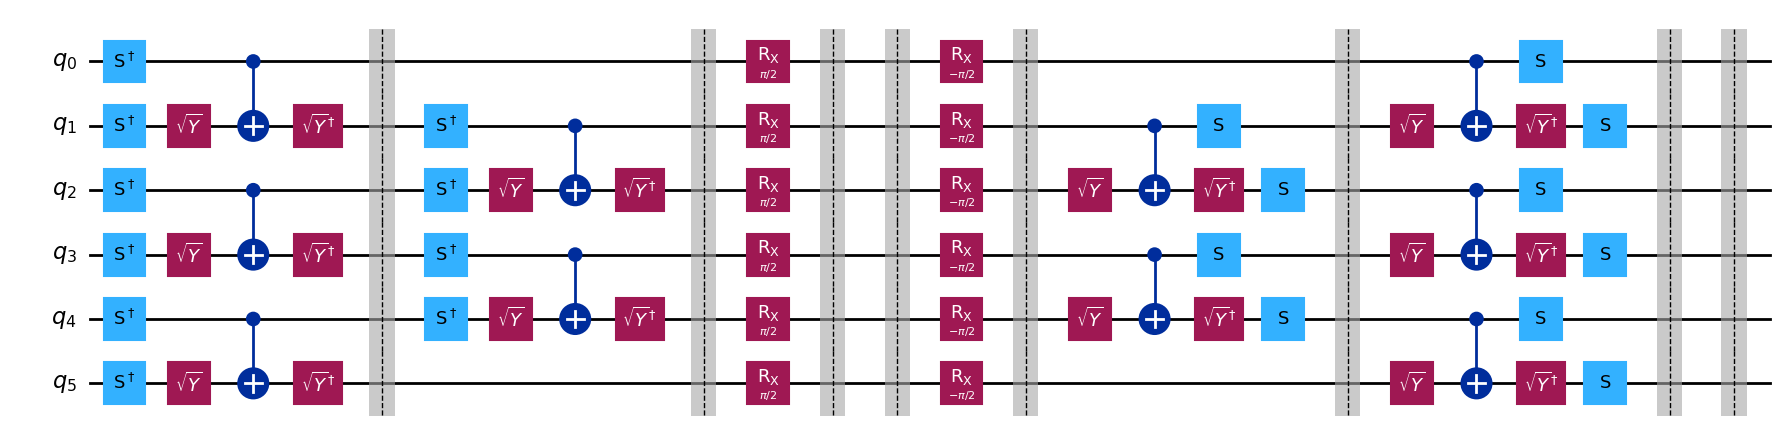

In [8]:
qc.draw(output = "mpl",fold = -1)

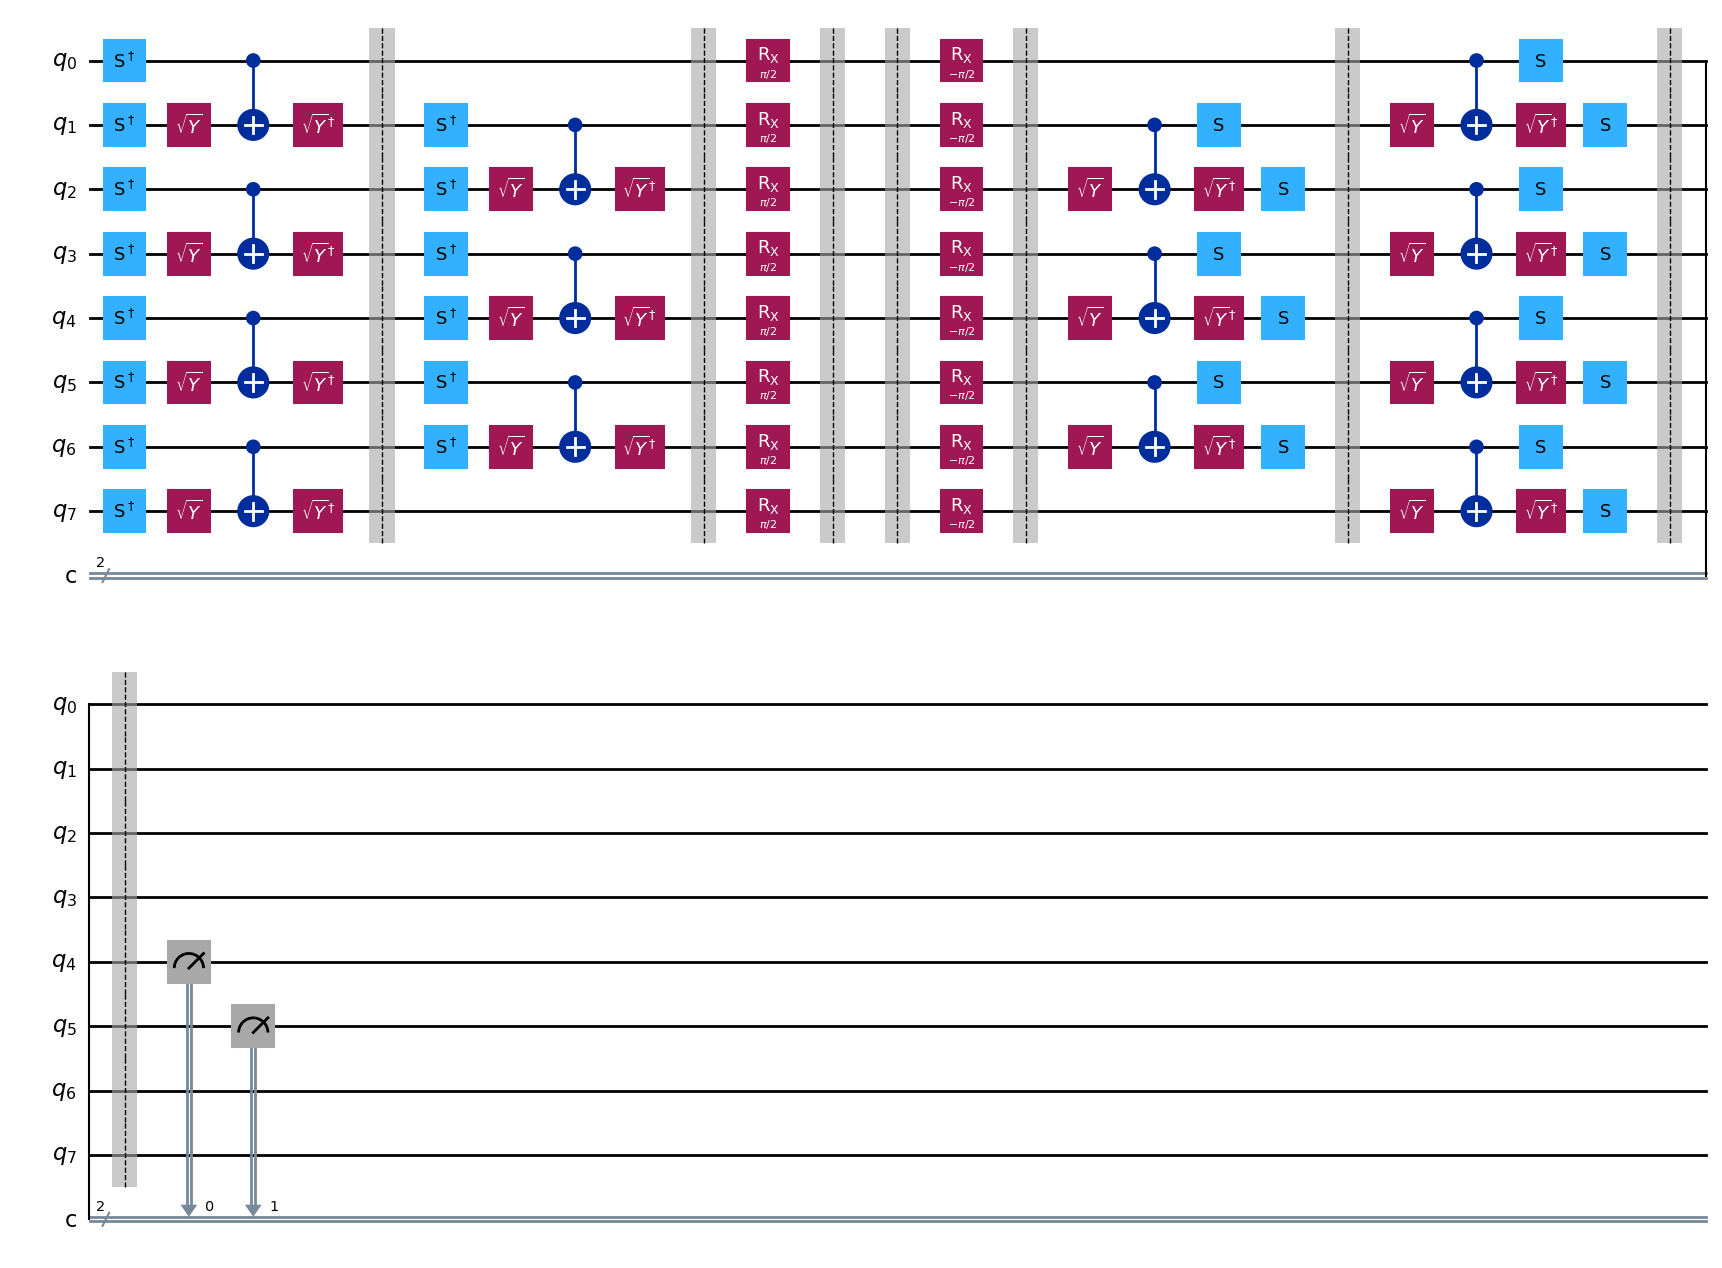

In [9]:
max_trotter_steps = 10
num_qubits = 8
measured_bits =[4,5]

qc_list = []
for trotter_steps in range(max_trotter_steps):
    qc = generate_1D_tfin_im(num_qubits,trotter_steps, rx_angle, num_cl_bits = len(measured_bits), trotter_barriers = True, layer_barriers = True)
    add_miirored_1D_tfin_im(qc, num_qubits,trotter_steps, rx_angle, trotter_barriers = True, layer_barriers = True)
    qc.measure(measured_bits,list(range(len(measured_bits))))
    qc_list.append(qc)

qc_list[1].draw(output = "mpl")
    
    
    

In [10]:
from qiskit import transpile
from qiskit_ibm_runtime import QiskitRuntimeService

backend_name = 'ibm_brisbane'
service = QiskitRuntimeService()
backend = service.get_backend(backend_name)
print('Done getting backend')


qc_transpiled_list = transpile(qc_list,backend = backend, optimization_level = 1)

AccountNotFoundError: 'Unable to find account.'

In [ ]:
from qiskit_ibm_runtime import SamplerV2 as Sampler

sampler = Sampler(backend=backend)
sampler.options.dynamical_decoupling.enable = True
sampler.options.dynamical_decoupling.sequence_type = 'XY4'

job = sampler.run(qc_transpiled_list)
print(job.job_id())

cs14q3c75q40008tmb5g


In [ ]:
job_id = 'cs09sbdkfpw00080b96g'
job = service.job(job_id)

survival_probability_list = []
for trotter_step in range(max_trotter_steps):
    try:
        data = job.result()[trotter_step].data
        survival_probability_list.append(data.c.get_counts()['0'*len(measured_bits)]/data.c.num_shots)
    except:
        survival_probability_list.append(0)
    

In [ ]:
import matplotlib.pyplot as plt

plt.plot(list(range(0,4*max_trotter_steps,4)),survival_probability_list,'--o')
plt.xlabel('2Q gate depth')
plt.ylabel('Survival probability of the all-0 bitstring')
plt.xticks(np.arange(0,44,4))
plt.show()

NameError: name 'survival_probability_list' is not defined

In [ ]:
from qiskit.circuit import Parameter
rx_angle = Parameter('rx_angle')
num_trotter_steps = 2
qc = generate_1D_tfin_im(num_qubits,num_trotter_steps, rx_angle)

from qiskit.quantum_info import SparsePauliOp

middle_index = num_qubits //2
observable = SparsePauliOp('I'*middle_index + 'Z' + 'I'*(middle_index-1))

In [ ]:
qc_transpiled = transpile(qc, backend=backend,optimization_level = 1)
observable =observable.apply_layout(qc_transpiled.layout)

In [ ]:
from qiskit_ibm_runtime import EstimatorV2, EstimatorOptions

min_rx_angle = 0
max_rx_angle = np.pi/2
num_rx_angle = 12

rx_angle_list = np.linspace(min_rx_angle,max_rx_angle,num_rx_angle)
options = EstimatorOptions()

options.resilience_level = 1
options.dynamical_decoupling.enable = True
options.dynamical_decoupling.sequence_type = 'XY4'

estimator = EstimatorV2(backend = backend,options = options)
job = estimator.run([(qc_transpiled, observable, rx_angle_list)])

print(job.job_id())

cs14q4m75q40008tmb60


## Coding the fsim gates, we create a function to add such gates

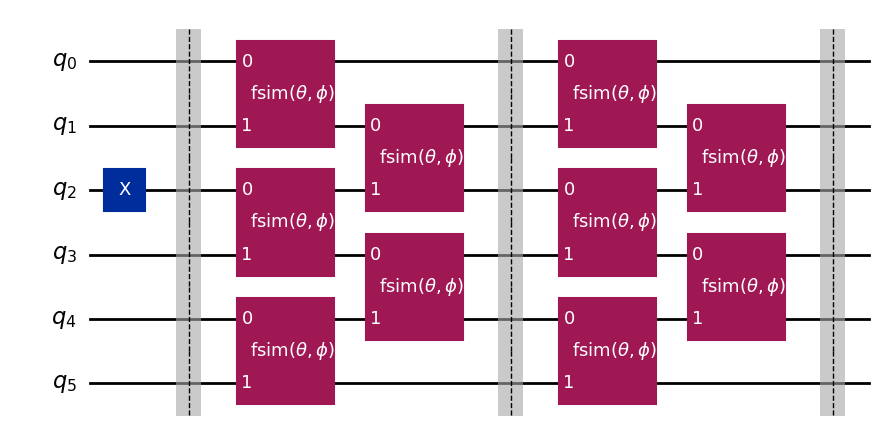

In [3]:
from qiskit.quantum_info import Operator
import math as m
import cmath as cm

def fsim(theta,phi,beta):
    fsim = Operator([[1,0,0,0],
                   [0,m.cos(theta),1j*cm.exp(1j*beta)*m.sin(theta),0],
                   [0,1j*cm.exp(-1j*beta)*m.sin(theta),m.cos(theta),0],
                   [0,0,0,cm.exp(1j*phi)]])
    return fsim

def circuit(num_qubits, pos1, trotter_steps,angles = [0,0,0], num_cl_bits = 0, trotter_barriers = False):
    if num_cl_bits == 0:
        qc = QuantumCircuit(num_qubits)
    else:
        qc = QuantumCircuit(num_qubits, num_cl_bits)
    qc.x(pos1-1)
    qc.barrier()
    for trotter_step in range(trotter_steps):
        add_fsim(qc,angles)
        if trotter_barriers:
            qc.barrier()
    return qc

def add_fsim(qc,angles):
    theta = angles[0]
    phi = angles[1]
    beta = angles[2]

    fsim1 = fsim(theta,phi,beta)
    #Adding fsim in even layers
    for i in range(0,qc.num_qubits-1,2):
        qc.unitary(fsim1,[i,i+1],label = r'fsim$(\theta,\phi)$')
        
    #Adding fsim in odd layers
    for i in range(1,qc.num_qubits-1,2):
        qc.unitary(fsim1,[i,i+1],label = r'fsim$(\theta,\phi)$')


num_qubits = 6
trotter_steps = 2
pos1 = 3
angles = [np.pi/4,0,0]
qc = circuit(num_qubits,pos1,trotter_steps,angles,trotter_barriers = True)
qc.draw(output = 'mpl')
    

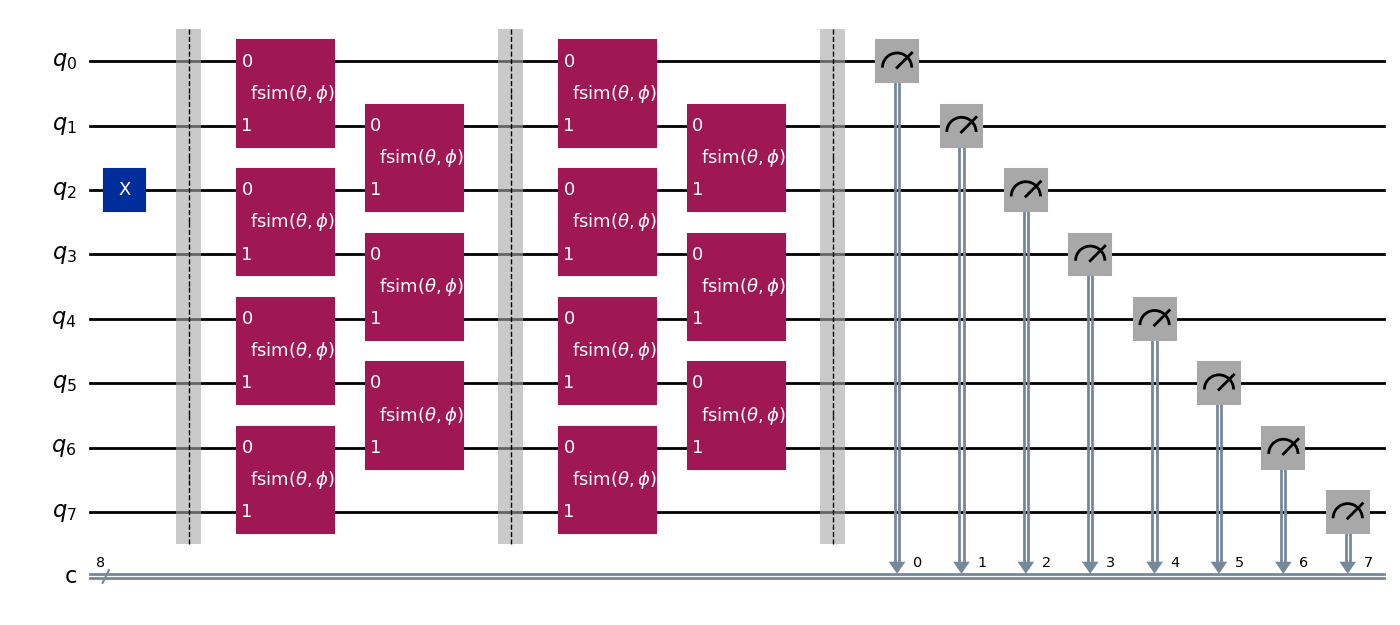

In [4]:
max_trotter_steps = 10
num_qubits = 8
measured_bits =[0,1,2,3,4,5,6,7]

qc_list = []
for trotter_steps in range(max_trotter_steps):
    qc = circuit(num_qubits,pos1, trotter_steps, angles, num_cl_bits = len(measured_bits), trotter_barriers = True)
    qc.measure(measured_bits,list(range(len(measured_bits))))
    qc_list.append(qc)

qc_list[2].draw(output = "mpl")

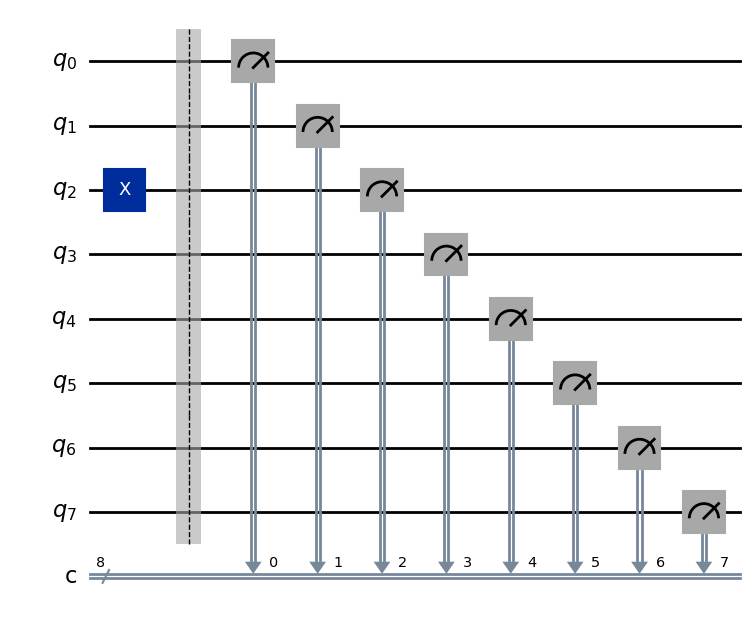

In [13]:
qc_list[0].draw(output = "mpl")

In [ ]:
qc_transpiled_list = transpile(qc_list,backend = backend, optimization_level = 1)

In [ ]:
#job = sampler.run(qc_transpiled_list)
#print(job.job_id())

cs14qadyhpyg008agn00


In [5]:
def required_bitsrings(num_qubits):
    bitstring_list = ['0'*i +'1' + '0'*(num_qubits-i-1) for i in range(num_qubits)]
    return bitstring_list

string_list = required_bitsrings(num_qubits)
for i in range(len(string_list)):
    string_list[i] = string_list[i][::-1]
print(string_list)


['00000001', '00000010', '00000100', '00001000', '00010000', '00100000', '01000000', '10000000']


[0.00146484375, 0.0009765625, 0.8212890625, 0.001220703125, 0, 0, 0.000732421875, 0.000244140625]
[0.004150390625, 0.00537109375, 0.002685546875, 0.022705078125, 0.6572265625, 0.00244140625, 0.000732421875, 0.00048828125]
[0.007080078125, 0.03271484375, 0.004150390625, 0.0078125, 0.003173828125, 0.001953125, 0.514892578125, 0.003662109375]
[0.02734375, 0.005615234375, 0.009765625, 0.005615234375, 0.005615234375, 0.004638671875, 0.00537109375, 0.40869140625]
[0.00341796875, 0.003662109375, 0.025390625, 0.005859375, 0.01123046875, 0.31103515625, 0.0107421875, 0.006591796875]
[0.0048828125, 0.004150390625, 0.0048828125, 0.28466796875, 0.01123046875, 0.00537109375, 0.0107421875, 0.005859375]
[0.002685546875, 0.23193359375, 0.005615234375, 0.00390625, 0.00732421875, 0.005859375, 0.009521484375, 0.00927734375]
[0.21728515625, 0.0078125, 0.010009765625, 0.003662109375, 0.007080078125, 0.0078125, 0.00537109375, 0.0087890625]
[0.010009765625, 0.00830078125, 0.147216796875, 0.009521484375, 0.011

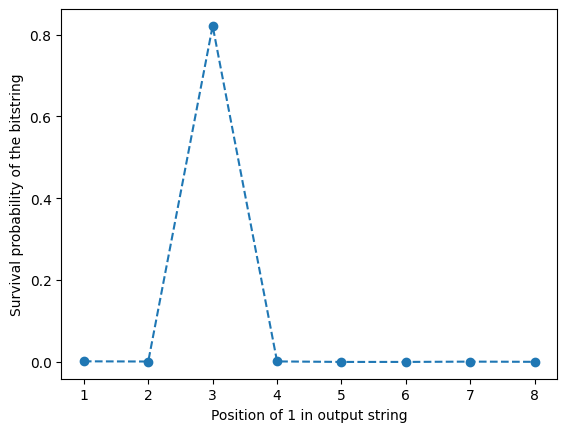

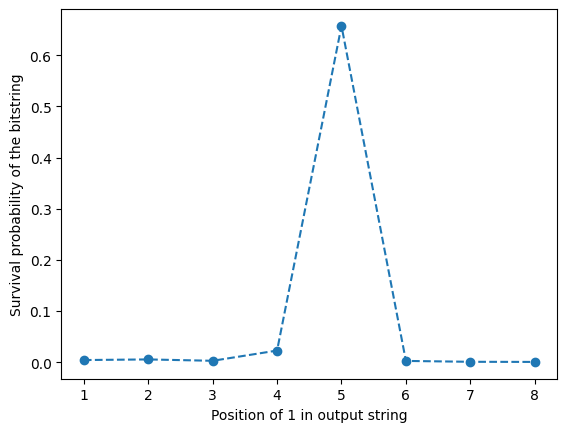

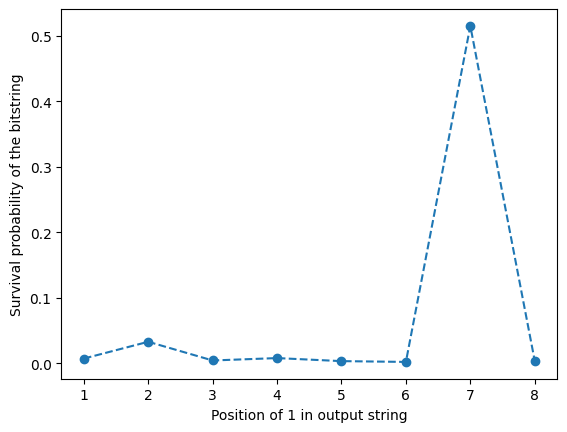

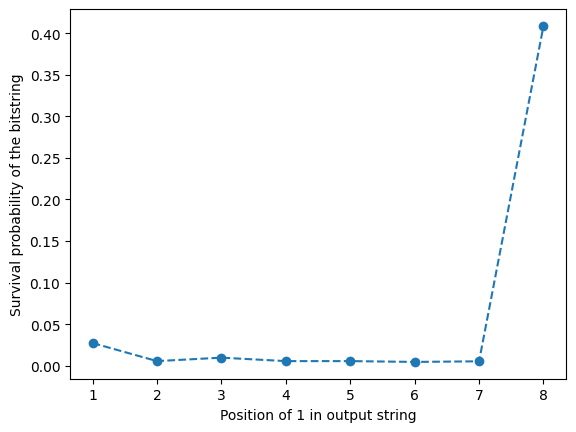

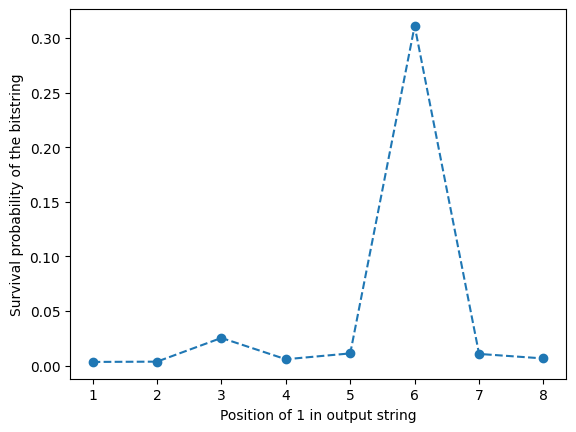

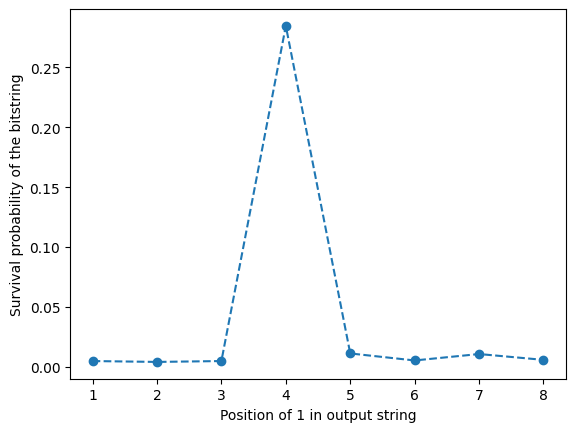

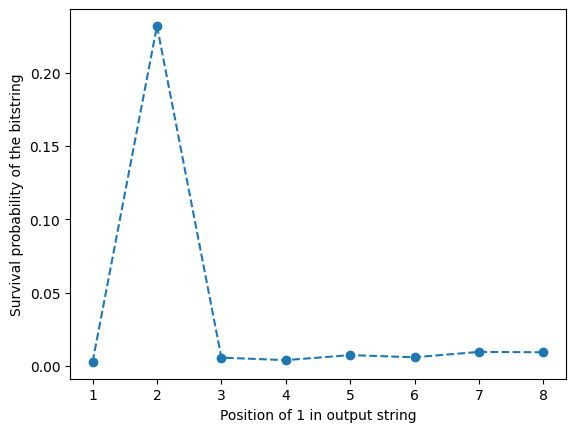

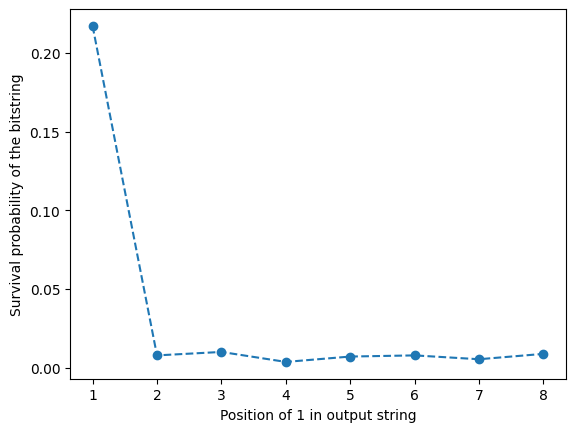

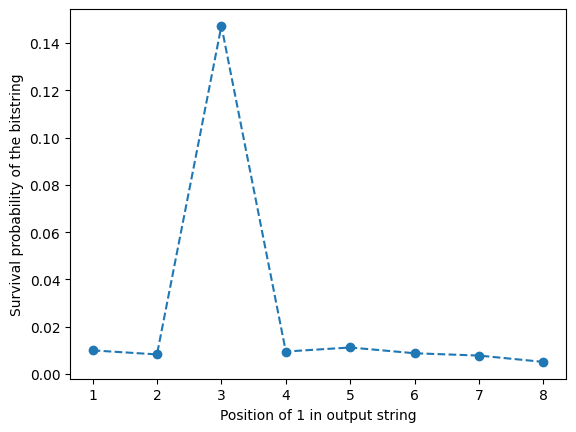

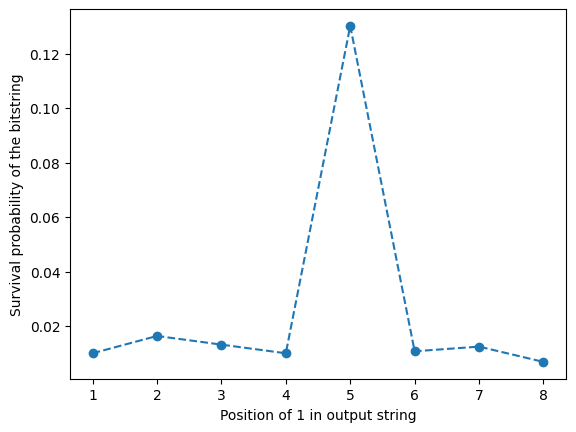

In [ ]:
job_id = 'cs0g0a1965y00084z3kg'
job = service.job(job_id)

string_distribution_list = []
for trotter_step in range(max_trotter_steps):
    data = job.result()[trotter_step].data
    list1 = []
    for i in string_list:
        try:
            list1.append(data.c.get_counts()[i]/data.c.num_shots)
        except:
            list1.append(0)
    print(list1)
    string_distribution_list.append(list1)

            
for trotter_step in range(max_trotter_steps):
    plt.plot(list(range(1,num_qubits+1)),string_distribution_list[trotter_step],'--o')
    plt.xlabel('Position of 1 in output string')
    plt.ylabel('Survival probability of the bitstring')
    plt.xticks(np.arange(1,9))
    plt.show()

[{4: 1.0}, {16: 0.25, 2: 0.25, 4: 0.25, 8: 0.25}, {1: 0.125, 16: 0.5625, 2: 0.0625, 32: 0.0625, 4: 0.0625, 64: 0.0625, 8: 0.0625}, {1: 0.182138347648319, 16: 0.0625, 2: 0.091069173824159, 32: 0.140625, 4: 0.039292478527522, 64: 0.390625, 8: 0.0625, 128: 0.03125}, {1: 0.0078125, 16: 0.082146239263761, 2: 0.114506673824159, 32: 0.0078125, 4: 0.152228760736239, 64: 0.287952065439602, 8: 0.026118326175841, 128: 0.321422934560398}, {1: 0.03125, 16: 0.005361652351682, 2: 0.00390625, 32: 0.007047033230885, 4: 0.239391684560398, 64: 0.01305916308792, 8: 0.091069173824159, 128: 0.608915042944956}, {1: 0.00652958154396, 16: 0.160711467280199, 2: 0.04553458691208, 32: 0.135953283230886, 4: 0.00067020654396, 64: 0.276558554192279, 8: 0.152228760736239, 128: 0.221813559560398}, {1: 0.0087890625, 16: 0.039292478527522, 2: 0.003712417177896, 32: 0.780100530483374, 4: 0.126112900690224, 64: 0.012910917369552, 8: 0.027573728527522, 128: 0.00150796472391}, {1: 0.000538589052896, 16: 0.191003999137329, 2

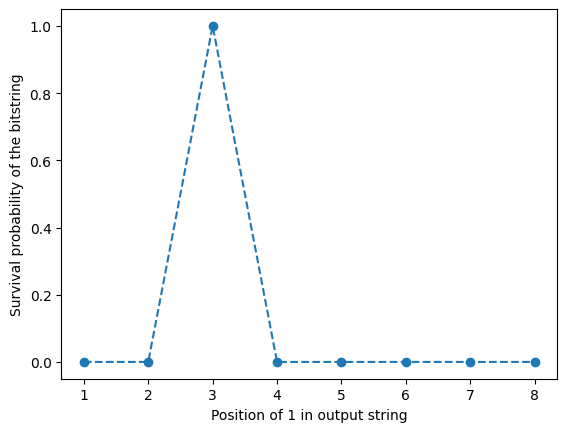

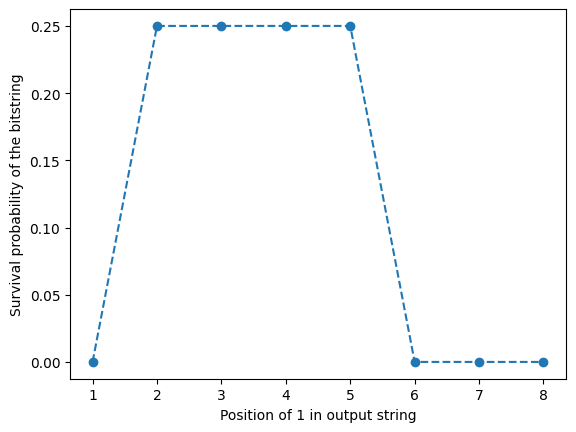

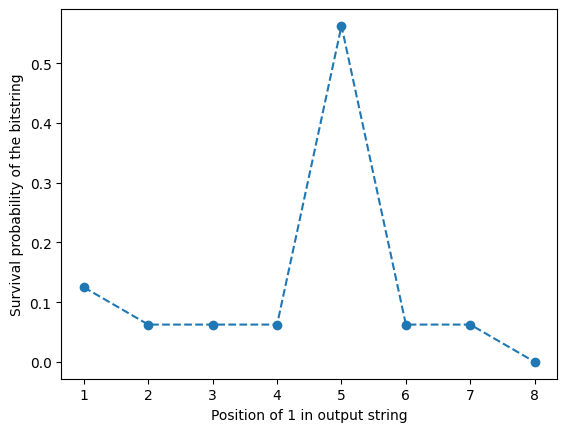

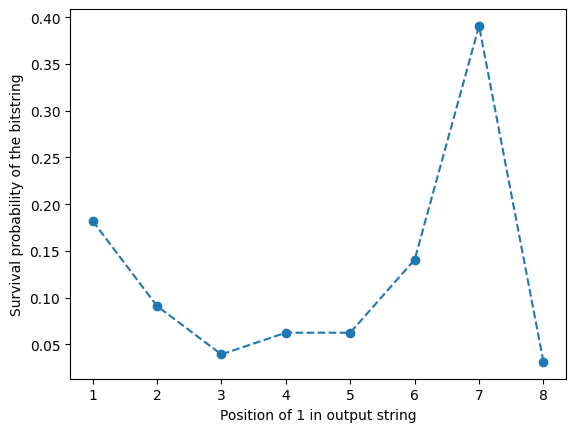

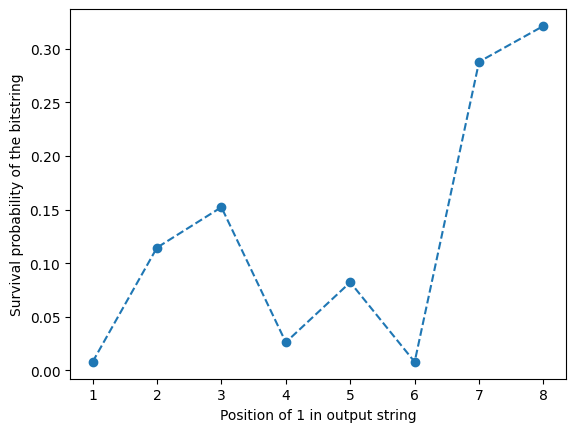

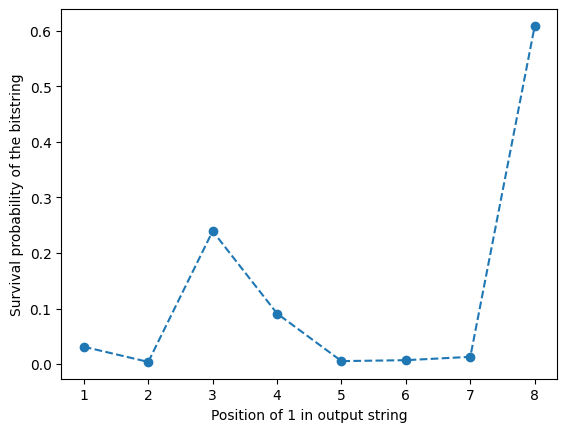

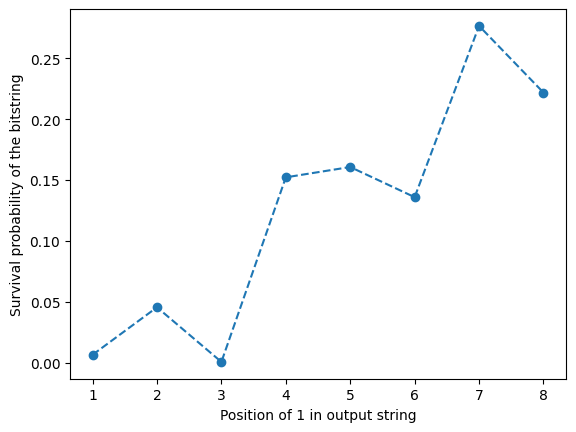

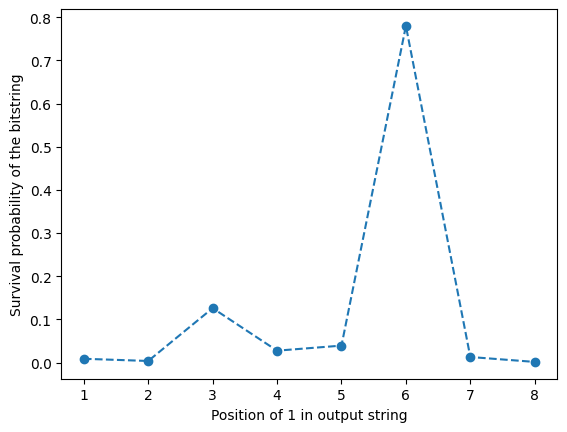

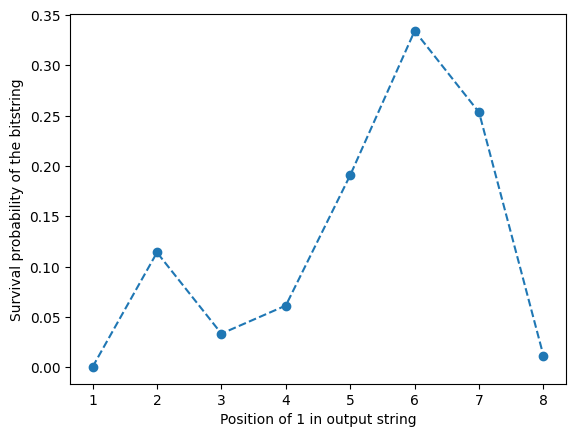

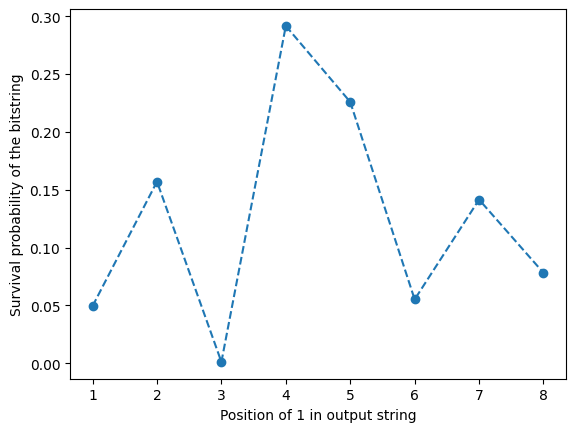

In [6]:
from qiskit_aer.primitives import Sampler
import matplotlib.pyplot as plt

sampler = Sampler()
job = sampler.run(qc_list,shots = None)
exact_quasis = job.result().quasi_dists
print(exact_quasis)

sim_distribution_list = []
for trotter_step in range(max_trotter_steps):
    data = job.result().quasi_dists[trotter_step]
    list1 = []
    for i in string_list:
        num = int(i,2)
        try:
            list1.append(data[num])
        except:
            list1.append(0)
        
    print(list1)
    sim_distribution_list.append(list1)


for trotter_step in range(max_trotter_steps):
    plt.plot(list(range(1,num_qubits+1)),sim_distribution_list[trotter_step],'--o')
    plt.xlabel('Position of 1 in output string')
    plt.ylabel('Survival probability of the bitstring')
    plt.xticks(np.arange(1,9))
    plt.show()

## Calculating the band structure for a ring arrangement

In [6]:
from qiskit_aer.primitives import Estimator
from qiskit.quantum_info import SparsePauliOp

def circuit_ring(num_qubits, pos1, trotter_steps,angles = [0,0,0], num_cl_bits = 0, trotter_barriers = False):
    if num_cl_bits == 0:
        qc = QuantumCircuit(num_qubits)
    else:
        qc = QuantumCircuit(num_qubits, num_cl_bits)
    qc.h(pos1-1)
    qc.barrier()
    for trotter_step in range(trotter_steps):
        add_fsim_ring(qc,angles)
        if trotter_barriers:
            qc.barrier()
    return qc

def add_fsim_ring(qc,angles):
    theta = angles[0]
    phi = angles[1]
    beta = angles[2]

    fsim1 = fsim(theta,phi,beta)
    #Adding fsim in even layers
    for i in range(0,qc.num_qubits-1,2):
        qc.unitary(fsim1,[i,i+1],label = r'fsim$(\theta,\phi,\beta)$')
        
    #Adding fsim in odd layers
    for i in range(1,qc.num_qubits-1,2):
        qc.unitary(fsim1,[i,i+1],label = r'fsim$(\theta,\phi,\beta)$')

    #Adding fsim between first and last qubit
    qc.unitary(fsim1,[qc.num_qubits-1,0],label = r'fsim$(\theta,\phi,\beta)$')

def estimate(qc_list,num_qubits):
    x_observables = [SparsePauliOp('I'*i + 'X' + 'I'*(num_qubits-1-i)) for i in range(num_qubits)]
    y_observables = [SparsePauliOp('I'*i + 'Y' + 'I'*(num_qubits-1-i)) for i in range(num_qubits)]
    #plus_obervables = x_observables + 1j*y_observables
    #plus_obervables= [observable.apply_layout(qc_transpiled_list.layout) for observable in plus_observables]

    estimator =  Estimator(approximation=True)
    job_x = estimator.run(qc_list,x_observables,shots = None)
    job_y = estimator.run(qc_list,y_observables,shots = None)
    expectation_list_x = list(job_x.result().values)
    expectation_list_y = list(job_y.result().values)

    expectation_list = [expectation_list_x[i] + 1j*expectation_list_y[i] for i in range(len(expectation_list_x))]

    return expectation_list

    
    


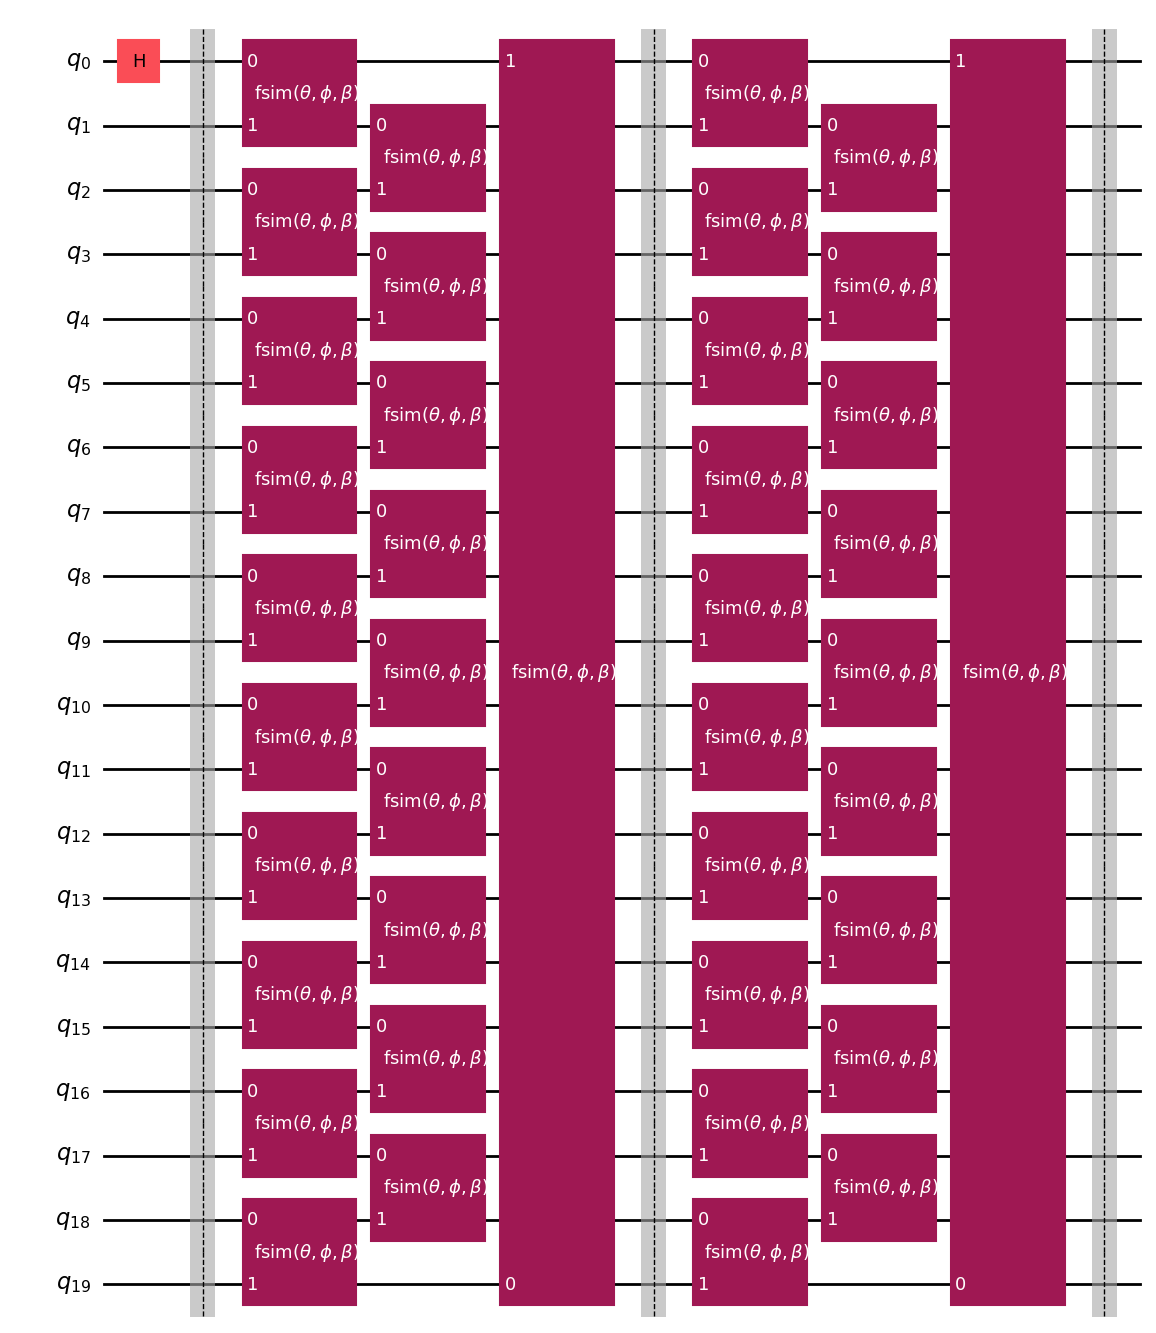

In [40]:
num_qubits = 20
num_trotter_steps = 20
angles = [np.pi/6,0,0]

pos1 = 1
trotter_steps = 2

qc = circuit_ring(num_qubits, pos1, trotter_steps,angles = angles, num_cl_bits = 0, trotter_barriers = True)
qc.draw(output='mpl')




In [41]:
evs_array = []
for trotter_step in range(num_trotter_steps):
    qc_list = []
    for pos in range(num_qubits):
        qc = circuit_ring(num_qubits, pos1, trotter_step,angles = angles)
        qc_list.append(qc)
    evs_array.append(estimate(qc_list,num_qubits))

evs_array_real = []
evs_array_imag = []
for i in evs_array:
    real_arr = [i[k].real for k in range(len(i))]
    imag_arr = [i[k].imag for k in range(len(i))]
    evs_array_real.append(real_arr)
    evs_array_imag.append(imag_arr)

print(evs_array_imag)
print(evs_array_real)
        
    


[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.4330127018922193, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.4330127018922193, 0.0], [0.5412658773652742, 0.0, -0.10825317547305481, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.10825317547305481, 0.0, 0.5412658773652742, 0.0], [0.27063293868263727, 0.0, -0.2976962325509007, 0.0, 0.027063293868263696, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.027063293868263692, 0.0, -0.29769623255090083, 0.0, 0.2706329386826373, 0.0], [-0.1285506458742524, 0.0, -0.41271523149102163, 0.0, 0.11501899894012071, 0.0, -0.006765823467065923, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0067658234670659205, 0.0, 0.11501899894012071, 0.0, -0.41271523149102163, 0.0, -0.12855064587425238, 0.0], [-0.32814243815269745, 0.0, -0.31799370295209883, 0.0, 0.25033546828143927, 0.0, -0.038903484935629055, 0.0, 0.0016914558667664805, 0.0, 0.0016914558667664795, 0

In [36]:
from qiskit_ibm_runtime import QiskitRuntimeService, EstimatorV2 as Estimator2
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

service = QiskitRuntimeService(channel = "ibm_quantum", #ibm_cloud
                               token = '60cc76a21936e2369c78f5c20e3aeafa53ce9611689830e893ca4ae55a556e12257888b95e65997248c6c64f75e79af7d183ce999c2d0e9077625aa5c03817a4')
#service.save_account(channel = "ibm_quantum", #ibm_cloud
                              #token = '60cc76a21936e2369c78f5c20e3aeafa53ce9611689830e893ca4ae55a556e12257888b95e65997248c6c64f75e79af7d183ce999c2d0e9077625aa5c03817a4')
backend = service.least_busy(operational=True, simulator=False, min_num_qubits=num_qubits)

print(backend.name)

pm = generate_preset_pass_manager(optimization_level=1, backend=backend)




    
    

IBMNotAuthorizedError: '401 Client Error: Unauthorized for url: https://auth.quantum-computing.ibm.com/api/users/loginWithToken. Login failed., Error code: 3446.'

In [128]:
def estimate2(qc_list,num_qubits):
    x_observables = [SparsePauliOp('I'*i + 'X' + 'I'*(num_qubits-1-i)) for i in range(num_qubits)]
    y_observables = [SparsePauliOp('I'*i + 'Y' + 'I'*(num_qubits-1-i)) for i in range(num_qubits)]

    pubs_x = []
    pubs_y = []

    for qc, obs in zip(qc_list, x_observables):
        isa_circuit = pm.run(qc)
        isa_obs = obs.apply_layout(isa_circuit.layout)
        pubs_x.append((isa_circuit, isa_obs))

    for qc, obs in zip(qc_list, y_observables):
        isa_circuit = pm.run(qc)
        isa_obs = obs.apply_layout(isa_circuit.layout)
        pubs_y.append((isa_circuit, isa_obs))

    estimator = Estimator2(backend)
    job_x = estimator.run(pubs_x)
    job_y = estimator.run(pubs_y)

    job_x_results = job_x.result()
    job_y_results = job_y.result()

    expectation_list = [job_x_results[i].data.evs + 1j*job_y_results[i].data.evs for i in range(num_qubits)]

    return expectation_list

evs_array2 = []
for trotter_step in range(num_trotter_steps):
    qc_list = []
    for pos in range(num_qubits):
        qc = circuit_ring(num_qubits, pos, trotter_step,angles = angles)
        qc_list.append(qc)
    evs_array2.append(estimate2(qc_list,num_qubits))

evs_array_real2 = []
evs_array_imag2 = []
for i in evs_array2:
    real_arr2 = [i[k].real for k in range(len(i))]
    imag_arr2 = [i[k].imag for k in range(len(i))]
    evs_array_real2.append(real_arr2)
    evs_array_imag2.append(imag_arr2)

print(evs_array_imag2)

NameError: name 'pm' is not defined

## Code to do Fourier transform

In [9]:
#Let us just see what happends if we use scipy's 2D FFT firstly

import scipy.fft as fft

fft_2d = fft.fft2(evs_array)
print(fft_2d)

[[ 1.77635684e-15+1.73205081e+00j  9.60593848e-01+1.62784575e+00j
  -2.04799772e+00+1.84755032e+00j  2.04799772e+00+1.84755032e+00j
  -9.60593848e-01+1.62784575e+00j -8.88178420e-16+1.73205081e+00j
  -2.29932079e+00+2.14753814e-01j -8.57685996e+00+1.60467520e+00j
   8.57685996e+00+1.60467520e+00j  2.29932079e+00+2.14753814e-01j]
 [-1.28716460e+00+3.96148528e+00j  3.75117989e-01+6.87228995e+00j
   4.99578328e+00-6.49091050e-01j  2.78718081e+00+1.94622916e+00j
  -2.12804212e+00+3.76666324e-01j -3.60113612e-01+1.10831574e+00j
  -1.34495358e+00+6.42820692e-01j -1.45416405e+00-6.49091050e-01j
  -6.41546324e+00-2.97768933e+00j  8.97564138e+00+2.86799904e+00j]
 [ 4.86984066e+00-6.70276064e+00j  1.09747153e+00-3.04740334e+00j
   1.89384380e+00+4.14010796e-01j  9.10410950e-01+1.34912227e+00j
  -3.48531135e-02+8.90228170e-01j -5.57210324e-01+7.66934216e-01j
  -7.34121919e-01-1.19915512e+00j -1.08589120e+00-7.29654235e-01j
  -1.74958889e+00-1.56866399e+00j -3.89158278e+00-2.54805292e+00j]
 [ 1.72

In [10]:
fft_2d_abs = np.abs(fft_2d)**2
print(fft_2d_abs)

[[ 3.          3.57262231  7.60773685  7.60773685  3.57262231  3.
   5.3329953  76.13750919 76.13750919  5.3329953 ]
 [17.35015835 47.36908264 25.37916973 11.55618482  4.67044077  1.35804558
   2.22211858  2.53591228 50.02480237 88.78755671]
 [68.64234823 10.49111087  3.75804929  2.648979    0.79372093  0.89867144
   1.976908    1.711555    5.52176801 21.63699019]
 [ 4.53351089  1.7776651   1.71292536  1.42446612  0.44660692  0.75828518
   1.1908741   1.18892519  2.17992745  3.88940571]
 [ 1.67509512  0.78870433  1.15530983  1.0638856   0.42757302  0.78388522
   1.07559809  1.01533554  1.32942365  1.8077406 ]
 [ 1.          0.51314283  0.99798412  0.99798412  0.51314283  1.
   1.22914299  1.05015059  1.05015059  1.22914299]
 [ 0.78388522  0.42757302  1.0638856   1.15530983  0.78870433  1.67509512
   1.8077406   1.32942365  1.01533554  1.07559809]
 [ 0.75828518  0.44660692  1.42446612  1.71292536  1.7776651   4.53351089
   3.88940571  2.17992745  1.18892519  1.1908741 ]
 [ 0.89867144  0

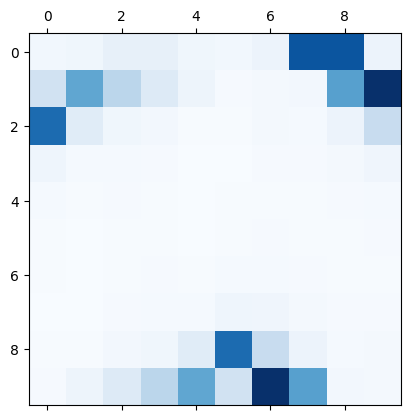

In [11]:
plt.matshow(fft_2d_abs, cmap=plt.cm.Blues)

In [38]:
#Making our own discrete fourier tansform function

def dft_2d(evs_array,n_k = num_qubits, n_w = num_trotter_steps):
    t = evs_array.shape[0]
    j = evs_array.shape[1]

    dft_arr = np.zeros((n_w,n_k),dtype=complex)
    w_arr = np.linspace(-np.pi,np.pi,n_w)  #can be updated for more points on the dft graph
    k_arr = np.linspace(-np.pi,np.pi,n_k)
    for i in range(n_w):
        for l in range(n_k):
            dft_arr[i,l] = exp_sum(evs_array,w_arr[i],k_arr[l])
            #print(dft_arr[i,l])
    dft_arr = 2*m.sqrt(num_qubits)*dft_arr/(n_k*n_w)

    return dft_arr

def exp_sum(evs_array,w,k):
    t = evs_array.shape[0]
    j = evs_array.shape[1]
    sum = 0 + 0j
    for n in range(t):
        for m in range(j):
            sum += evs_array[n,m]*cm.exp(-1j*(w*n - k*m))

    #sum_real = sum.real
    #sum_imag = sum.imag
    return sum

In [42]:
evs_array = np.array(evs_array)
print(evs_array)

[[ 0.00000000e+00+0.j          0.00000000e+00+0.j
   0.00000000e+00+0.j          0.00000000e+00+0.j
   0.00000000e+00+0.j          0.00000000e+00+0.j
   0.00000000e+00+0.j          0.00000000e+00+0.j
   0.00000000e+00+0.j          0.00000000e+00+0.j
   0.00000000e+00+0.j          0.00000000e+00+0.j
   0.00000000e+00+0.j          0.00000000e+00+0.j
   0.00000000e+00+0.j          0.00000000e+00+0.j
   0.00000000e+00+0.j          0.00000000e+00+0.j
   0.00000000e+00+0.j          1.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.4330127j   0.00000000e+00+0.j
   0.00000000e+00+0.j          0.00000000e+00+0.j
   0.00000000e+00+0.j          0.00000000e+00+0.j
   0.00000000e+00+0.j          0.00000000e+00+0.j
   0.00000000e+00+0.j          0.00000000e+00+0.j
   0.00000000e+00+0.j          0.00000000e+00+0.j
   0.00000000e+00+0.j          0.00000000e+00+0.j
   0.00000000e+00+0.j          0.00000000e+00+0.j
   0.00000000e+00+0.j         -2.50000000e-01+0.j
   0.00000000e+00+0.4330127j   7.50000000

In [14]:
import matplotlib.pyplot as plt

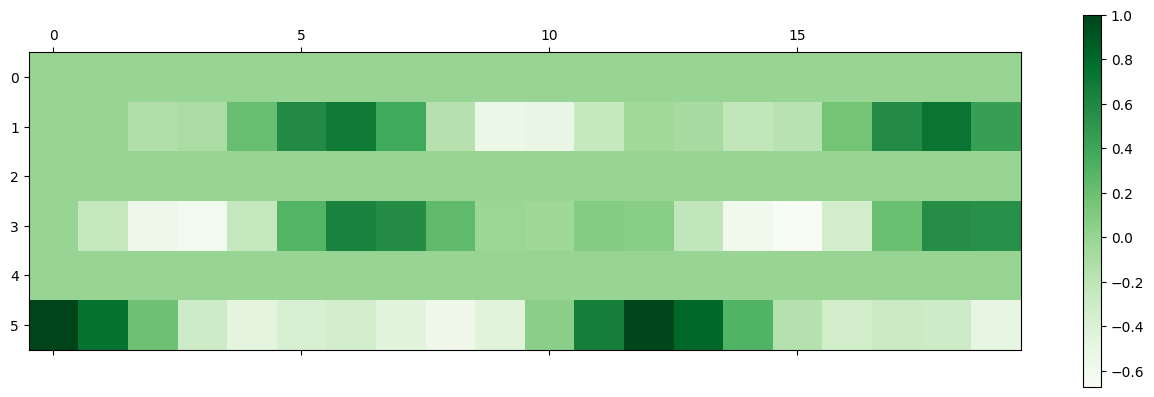

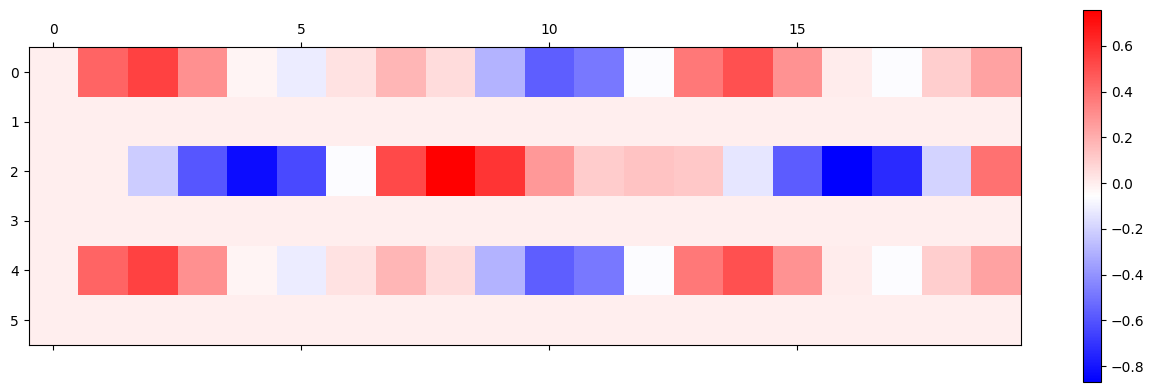

In [32]:
import matplotlib.pyplot as plt

evs_array_real = np.array(evs_array_real).T
evs_array_imag = np.array(evs_array_imag).T
plt.matshow(evs_array_real, cmap=plt.cm.Greens)
plt.colorbar()
plt.matshow(evs_array_imag, cmap=plt.cm.bwr)
plt.colorbar()

([<matplotlib.axis.YTick at 0x1dec173bd70>,
 [Text(0, 0, '-1.0'),
  Text(0, 4, '-0.58'),
  Text(0, 8, '-0.16'),
  Text(0, 12, '0.26'),
  Text(0, 16, '0.68')])

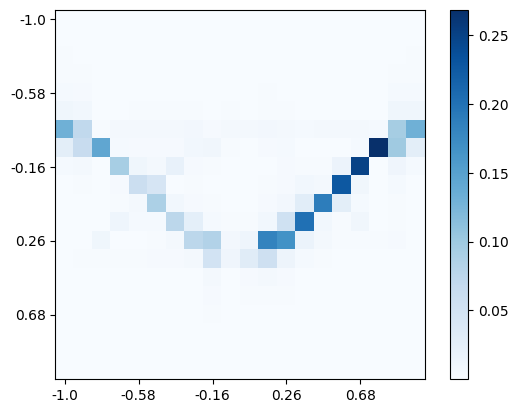

In [55]:
dft_array = dft_2d(evs_array,n_k=20,n_w=20)
dft_array = np.abs(dft_array)**2
plt.imshow(dft_array, cmap=plt.cm.Blues)
plt.colorbar()

x = np.linspace(-1,1,20) # the grid to which your data corresponds
x = np.array([round(i,2) for i in x])
nx = x.shape[0]
no_labels = 6 # how many labels to see on axis x
step_x = int(nx / (no_labels - 1)) # step between consecutive labels
x_positions = np.arange(0,nx,step_x) # pixel count at label position
x_labels = x[::step_x] # labels you want to see
#print(x_labels)
plt.xticks(x_positions,x_labels)

y = np.linspace(-1,1,20) # the grid to which your data corresponds
y = np.array([round(i,2) for i in y])
ny = y.shape[0]
no_labels = 6 # how many labels to see on axis x
step_y = int(ny / (no_labels - 1)) # step between consecutive labels
y_positions = np.arange(0,ny,step_y) # pixel count at label position
y_labels = y[::step_y] # labels you want to see
#print(x_labels)
plt.yticks(y_positions,y_labels)


In [ ]:
from qiskit_aer import AerSimulator
from qiskit.circuit.library import RealAmplitudes
from qiskit.circuit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.quantum_info import SparsePauliOp
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import Session, SamplerV2 as Sampler
 
# Bell Circuit
qc = QuantumCircuit(2)
qc.h(0)
qc.cx(0, 1)
qc.measure_all()
 
# Run the sampler job locally using AerSimulator.
# Session syntax is supported but ignored because local mode doesn't support sessions.
aer_sim = AerSimulator()
pm = generate_preset_pass_manager(backend=aer_sim, optimization_level=1)
isa_qc = pm.run(qc)
with Session(backend=aer_sim) as session:
    sampler = Sampler(session=session)
    result = sampler.run([isa_qc]).result()

/home/sarma/miniconda3/envs/qiskitenv/lib/python3.12/site-packages/qiskit_ibm_runtime/session.py:157: UserWarning: Session is not supported in local testing mode or when using a simulator.
  warnings.warn(


In [ ]:
print(result)

PrimitiveResult([PubResult(data=DataBin<>(meas=BitArray(<shape=(), num_shots=1024, num_bits=2>)))], metadata={})


In [58]:
## Let us plot the analytical dispersion relation now

def dispersion(k,theta):
    c_eff = m.cos(theta)**2 - m.cos(k)*m.sin(theta)**2
    s_eff = np.sqrt(1 - c_eff**2)
    if s_eff == 0:
         s_eff = 0.001
    theta_eff = m.acos(c_eff)
    val = m.cos(theta)**2 + (m.sin(k/2)**2)*m.sin(theta)**2
    return (theta_eff/s_eff)*(2*abs(m.cos(k/2))*m.sin(theta)*np.sqrt(val))

def disp_plot(k_arr,theta):
    w_arr = []
    for k in k_arr:
        w_arr.append(dispersion(k,theta))
    return w_arr

Text(0, 0.5, 'w')

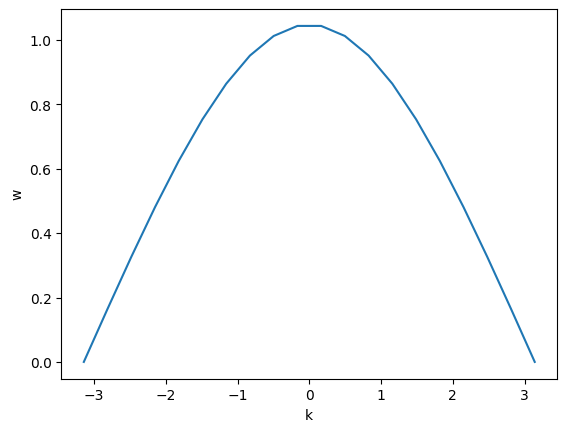

In [60]:
theta_check = np.pi/6
k_arr = np.linspace(-np.pi,np.pi,20)

w_arr = disp_plot(k_arr,theta_check)
plt.plot(k_arr,w_arr,label = "Dispersion relation")
plt.xlabel("k")
plt.ylabel("w")

In [74]:
a = [0,1,2,3]
b = [1,2,3,4]
print(zip(a,b))

[7, 4, 2, 0, 0, 0, 0, 2, 4, 7]
[[0. 0. 0. 1. 1. 1. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


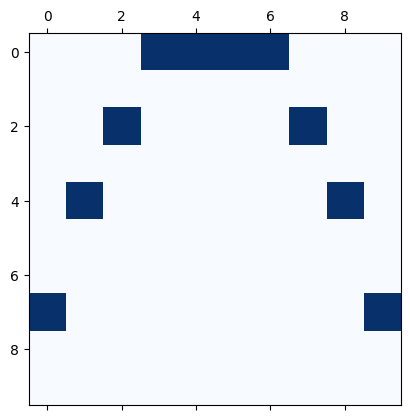

In [79]:
## Let's try to do a mathsow of the above plot

def check_closest(w,val_list,k_arr):
    dis = 10000  #some high value
    ind = 0
    for i in range(len(k_arr)):
        if abs(w-k_arr[i])<dis:
            ind = val_list[i]
            dis = abs(w-k_arr[i])
    return ind


val_list = list(range(len(k_arr)))
k_diff_arr = np.linspace(-0.8,0.2,10)
#check_list = zip(,k_arr)
ind_list =[]
for w in w_arr:
    ind_list.append(check_closest(w,val_list,k_diff_arr))

print(ind_list)

disp_mat = np.zeros((len(k_arr),len(k_arr)))
for i,j in zip(list(range(len(k_arr))),ind_list):
    disp_mat[j,i] = 1

plt.matshow(disp_mat, cmap=plt.cm.Blues)

print(disp_mat)
    


[1, (0.0063268848046472564+0.0246822622028765j), (0.008246210614970908-0.004497577283614746j), (-0.09483428372681937-0.05116325084906185j), (-0.00030700752688081164-0.02077374157263413j), (-0.009775749347575812+0.0162825746788915j), (0.07520001138226215-0.05780391979082098j), (-0.05733962518932637-0.19038346946325593j), (0.10566153593932388-0.2926917747871243j), (0.03210964651964141-0.06665619080336095j), (-0.20957222541231588+0.14467464745217648j), (-0.13647528770967238+0.46101075192649255j), (0.09152455543830224+0.1444038180390782j), (-0.040590502132773834+0.13429620092068456j), (-0.019002543853971248+0.02805760684977813j), (0.008398561162323227+0.05515214481879936j), (-0.041720498469929+0.08182072290493268j), (-0.020873842222506465+0.06098982672703409j), (-0.005161269836854372+0.042693615444329786j), 1]
[1, 0.0006492435387828223, 8.822819092854628e-05, 0.011611219607422908, 0.00043164259254814915, 0.0003606875134803076, 0.00899633485507602, 0.03953369806171895, 0.09683283520509375, 

C:\Users\DELL\AppData\Local\Temp\ipykernel_56560\2162833315.py:37: ComplexWarning: Casting complex values to real discards the imaginary part
  dft_mat[i,l] = exp_sum(evs_array,w_arr[i],k_arr[l])


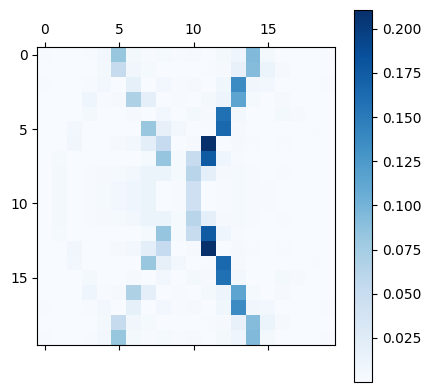

In [61]:
## Let us just pass the w_arr to the dft 2d function to see what happens

def dft_2d_2(w_arr,k_arr,evs_array):
    #t = evs_array.shape[0]
    #j = evs_array.shape[1]

    #dft_arr = np.zeros((n_w,n_k),dtype=complex)
    #w_arr = np.linspace(-np.pi,np.pi,n_w)  #can be updated for more points on the dft graph
    #k_arr = np.linspace(-np.pi,np.pi,n_k)

    amp_arr = []
    for i in range(len(k_arr)):
            amp_arr.append(exp_sum(evs_array,w_arr[i],k_arr[i]))
            #print(exp_sum(evs_array,w_arr[i],k_arr[i]))
    amp_arr = [2*m.sqrt(num_qubits)*k/(len(k_arr)*len(w_arr)) for k in amp_arr]

    return amp_arr

amp_arr = dft_2d_2(w_arr,k_arr,evs_array)
for i in range(len(amp_arr)):
    if i == 0 or i == len(amp_arr)-1:
        amp_arr[i] = 1
print(amp_arr)

amp_square_arr = [np.abs(k)**2 for k in amp_arr]
print(amp_square_arr)


## Let us try to plot the above array

def dft_matshow_2(w_arr,k_arr,evs_array):
    dft_mat = np.zeros((len(k_arr),len(k_arr)))
    n_k = len(k_arr)
    n_w = len(w_arr)
    for i in range(n_w):
        for l in range(n_k):
            dft_mat[i,l] = exp_sum(evs_array,w_arr[i],k_arr[l])
            #print(dft_arr[i,l])
    dft_mat = 2*m.sqrt(num_qubits)*dft_mat/(n_k*n_w)

    dft_mat = np.abs(dft_mat)**2
    plt.matshow(dft_mat, cmap=plt.cm.Blues)
    plt.colorbar()


dft_matshow_2(w_arr,k_arr,evs_array)




In [62]:
print(dft_array)
print()
print(dft_array[0,:])
print()
print(dft_array[:,0])

[[5.00000000e-04 1.43376589e-04 4.76142399e-04 5.35379578e-05
  3.09169077e-05 4.37013886e-05 7.77211291e-05 2.18509962e-04
  4.96167211e-04 2.20515362e-04 1.92621097e-05 2.67219994e-04
  8.53896734e-05 3.77542478e-05 1.68082309e-05 2.16755551e-05
  1.18318036e-04 4.61254552e-04 2.00616566e-04 5.00000000e-04]
 [7.35961635e-04 3.02032059e-04 4.36412756e-04 4.06517398e-05
  6.50543941e-05 9.70420411e-05 1.59272233e-04 3.17450836e-04
  3.62923615e-04 2.54212781e-04 3.28164362e-07 3.56476012e-04
  6.40808231e-05 7.16293946e-06 1.78395918e-06 6.27332716e-06
  7.26715316e-05 5.06077842e-04 3.87743884e-04 7.35961635e-04]
 [1.11661857e-03 5.88550902e-04 3.97179859e-04 5.31696899e-05
  1.38062914e-04 1.91162393e-04 2.85790858e-04 4.56834199e-04
  2.56009225e-04 3.09437841e-04 2.26409089e-05 4.99589227e-04
  1.01477697e-04 3.00857220e-06 8.75048123e-06 1.13358992e-05
  3.13948540e-05 5.57403232e-04 7.32459629e-04 1.11661857e-03]
 [1.82188064e-03 1.15926212e-03 3.56709328e-04 1.15036101e-04
  2.7

In [63]:
print(w_arr)

def max_ind(arr):
    max_val = max(arr)
    for i in range(len(arr)):
        if arr[i] == max_val:
            return i
        
def avg_arr(arr,k_arr):
    val = 0
    sum = 0
    for i in range(len(arr)):
        sum+=arr[i]
    for i in range(len(arr)):
        val += arr[i]*k_arr[i] #weighted sum

    return val/sum

w_num_arr = []
for j in range(len(k_arr)):
    ind = max_ind(dft_array[:,j])
    w_num_arr.append(ind)

w_final_arr2 = []
for j in range(len(k_arr)):
    w_final_arr2.append(avg_arr(dft_array[:,j],k_arr))
    

print(w_num_arr)
print(dft_array[2,:])
    

[0.0, 0.16478095444046345, 0.32614303175595855, 0.48055815660179635, 0.6243019110930682, 0.7534174071952301, 0.8637695108808016, 0.9512331217786284, 1.012040609395547, 1.0432559033934092, 1.0432559033934092, 1.012040609395547, 0.9512331217786286, 0.8637695108808019, 0.7534174071952302, 0.6243019110930683, 0.48055815660179635, 0.32614303175595855, 0.16478095444046345, 0.0]
[6, 6, 7, 8, 9, 10, 11, 12, 12, 13, 13, 12, 12, 11, 10, 9, 8, 7, 7, 6]
[1.11661857e-03 5.88550902e-04 3.97179859e-04 5.31696899e-05
 1.38062914e-04 1.91162393e-04 2.85790858e-04 4.56834199e-04
 2.56009225e-04 3.09437841e-04 2.26409089e-05 4.99589227e-04
 1.01477697e-04 3.00857220e-06 8.75048123e-06 1.13358992e-05
 3.13948540e-05 5.57403232e-04 7.32459629e-04 1.11661857e-03]


In [64]:
print(k_arr)
print(w_final_arr2)

[-3.14159265 -2.81089869 -2.48020473 -2.14951076 -1.8188168  -1.48812284
 -1.15742887 -0.82673491 -0.49604095 -0.16534698  0.16534698  0.49604095
  0.82673491  1.15742887  1.48812284  1.8188168   2.14951076  2.48020473
  2.81089869  3.14159265]
[-1.1211728433079053, -0.9929468344203827, -0.6553943041862406, -0.3957976386761798, -0.23650199465144384, -0.009749795923339324, 0.17193884427036515, 0.42934090057736785, 0.8182894908292354, 0.26304734384663825, 0.8471383116502021, 0.7778736160676242, 0.6713076728445552, 0.44028848282882505, 0.15620072653906428, -0.16088540666657572, -0.44574032957806453, -0.8108037236742962, -0.9586203711221456, -1.1211728433079058]


In [65]:
w_final_arr2_plot = [i/np.pi for i in w_final_arr2]

In [66]:
w_final_arr3 = [(i+1)/(2*np.pi) for i in w_final_arr2]

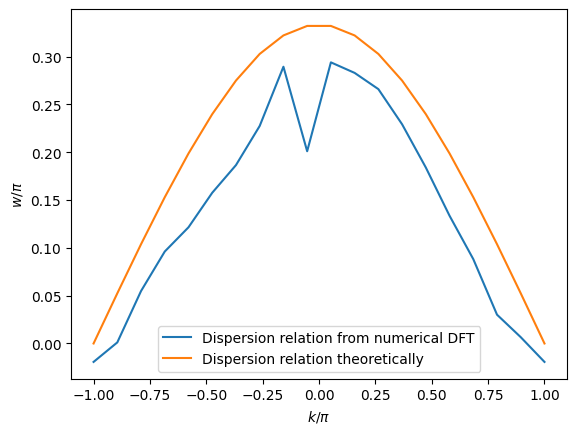

In [67]:
w_final_arr  = [(k_arr[i] +1)/(2*np.pi) for i in w_num_arr]
k_arr_plot = [k/np.pi for k in k_arr]

w_arr_plot = [w/np.pi for w in w_arr]
  #scaling the graph properly

plt.plot(k_arr_plot,w_final_arr3,label = "Dispersion relation from numerical DFT")
plt.plot(k_arr_plot,w_arr_plot,label = "Dispersion relation theoretically")
plt.xlabel(r"$k/\pi$")
plt.ylabel(r"$w/\pi$")
plt.legend()  #dispersion matches the google paper well, but analytics are scaled a bit differently!

([<matplotlib.axis.YTick at 0x1dec72b1b50>,
 [Text(0, 0, '-1.0'),
  Text(0, 6, '-0.37'),
  Text(0, 13, '0.37'),
  Text(0, 19, '1.0')])

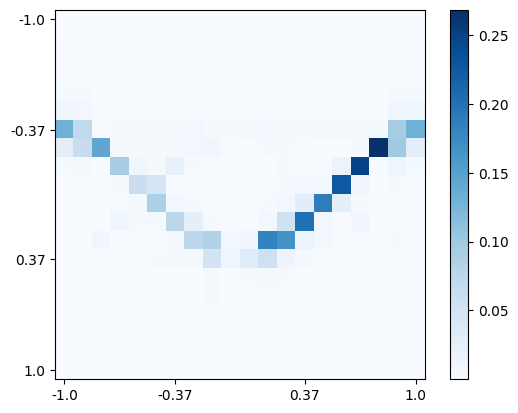

In [93]:
## Let us try to arrange the imshow and the plot in a single plot

dft_array = dft_2d(evs_array,n_k=20,n_w=20)
dft_array = np.abs(dft_array)**2
plt.imshow(dft_array, cmap=plt.cm.Blues)
plt.colorbar()

x = np.linspace(-1,1,20) # the grid to which your data corresponds
x = [round(i,2) for i in x]
nx = len(x)
no_labels = 4.2 # how many labels to see on axis x
step_x = int(nx / (no_labels - 1)) # step between consecutive labels
x_positions = list(np.arange(0,nx,step_x))
x_positions[2] = 13
x_positions.pop()
x_positions.append(nx-1) # pixel count at label position

x_labels = [x[i] for i in x_positions]
#x_labels.append(x[-1])
#print(x_labels)
plt.xticks(x_positions,x_labels)

y = np.linspace(-1,1,20) # the grid to which your data corresponds
y = [round(i,2) for i in y]
ny = len(y)
no_labels = 4.2 # how many labels to see on axis x
step_y = int(ny / (no_labels - 1)) # step between consecutive labels
y_positions = list(np.arange(0,ny,step_y))

y_positions[2] = 13
y_positions.pop()
y_positions.append(ny-1) # pixel count at label position
y_labels = [y[i] for i in y_positions] # labels you want to see
#y_labels.append(y[-1])#print(x_labels)
plt.yticks(y_positions,y_labels)

#plt.plot(k_arr_plot,w_arr_plot,label = "Dispersion relation from numerical DFT")

[-0.3333333333333333, -0.3135918629069766, -0.2582130516198476, -0.17634555400879498, -0.07833800757303759, 0.026293296634835754, 0.12873928123711598, 0.21993427801559817, 0.28985659970768307, 0.32833168717859246, 0.32833168717859246, 0.28985659970768307, 0.21993427801559834, 0.12873928123711606, 0.026293296634835827, -0.07833800757303752, -0.17634555400879498, -0.2582130516198476, -0.3135918629069766, -0.3333333333333333]


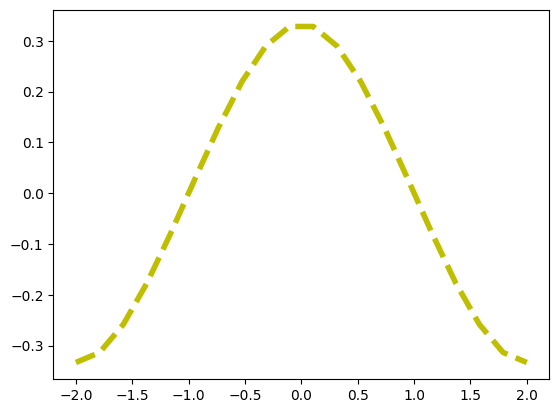

In [95]:
def disp_plot_fin(k_arr,theta):
    w_arr = []
    for k in k_arr:
        if -2*np.pi <= k <= -np.pi:
            w_arr.append(-dispersion(2*np.pi + k,theta))
        elif np.pi <= k <= 2*np.pi:
            w_arr.append(-dispersion(k - 2*np.pi,theta))
        else:
            w_arr.append(dispersion(k,theta))
    return w_arr

k_arr = np.linspace(-2*np.pi,2*np.pi,20)

k_arr_fin = [k/np.pi for k in k_arr]
w_arr = disp_plot_fin(k_arr,theta_check)

w_arr_fin = [w/np.pi for w in w_arr]

plt.plot(k_arr_fin,w_arr_fin,'y--',linewidth = 4.0,label = r"$\theta = \pi/6$")

print(w_arr_fin)




In [97]:
super_w_arr = []

for theta in [np.pi/4,np.pi/6,np.pi/8,np.pi/10]:
    w_int = disp_plot_fin(k_arr,theta)
    w_int_fin = [w/np.pi for w in w_int]
    super_w_arr.append(w_int_fin)






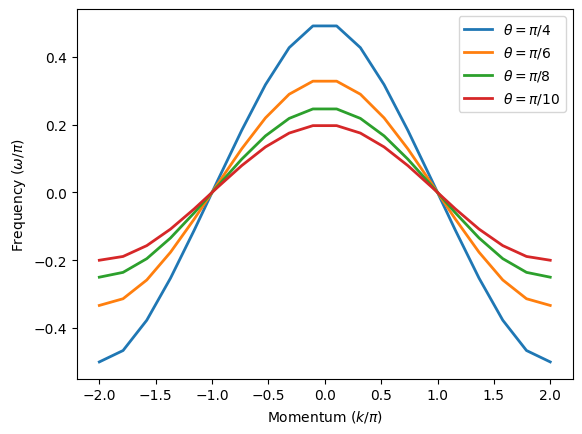

In [100]:
plt.plot(k_arr_fin,super_w_arr[0],'-',linewidth = 2.0,label = r"$\theta = \pi/4$")
plt.plot(k_arr_fin,super_w_arr[1],'-',linewidth = 2.0,label = r"$\theta = \pi/6$")
plt.plot(k_arr_fin,super_w_arr[2],'-',linewidth = 2.0,label = r"$\theta = \pi/8$")
plt.plot(k_arr_fin,super_w_arr[3],'-',linewidth = 2.0,label = r"$\theta = \pi/10$")
plt.xlabel(r"Momentum $(k/\pi)$")
plt.ylabel(r"Frequency $(\omega/\pi)$")
plt.legend()

# This marks the end of dispersion results